# Проект: классификация

Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, f_classif

In [467]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [468]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bank_fin.csv', sep = ';')

In [469]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()
# В данных имеется 25 пропусков в признаке balance

,0
age,0
job,0
marital,0
education,0
default,0
balance,25
housing,0
loan,0
contact,0
day,0


### Задание 2

In [470]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.job.value_counts()
# Пропущенное значение unknown

,count
job,
management,2566
blue-collar,1944
technician,1823
admin.,1334
services,923
retired,778
self-employed,405
student,360
unemployed,357


### Задание 3

In [471]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df.balance = df.balance.apply(lambda x: float(str(x).replace(' ', '').replace('$','').replace(',','.')))
df.balance.mean().round(3)

np.float64(1529.129)

### Задание 4

In [472]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df.loc[(df['balance'].isnull() == True), 'balance'] = df['balance'].median()
# Вычислите среднее значение по преобразованному в корректный вид признаку balance. Ответ округлите до трёх знаков после точки-разделителя.
df.balance.mean().round(3)

np.float64(1526.936)

### Задание 5

In [473]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# 1. Находим моды:
popular_job = df['job'].mode()[0]
popular_education = df['education'].mode()[0]

# 2. Потом делаем замены:

df['job'] = df['job'].apply(lambda x: popular_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: popular_education if x == 'unknown' else x)

# Выбрать строки с самой популярной работой и уровнем образования
selected_rows = df[(df['job'] == popular_job) & (df['education'] == popular_education)]

# Рассчитать средний баланс для выбранных клиентов и округлить до 3 знаков после запятой
selected_rows.balance.mean().round(3)

np.float64(1598.883)

### Задание 6

In [474]:
# удалите все выбросы для признака balance
# Определим границы выбросов при помощи мтода Тьюки
# Определение квартилей и IQR
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

# Коэффициент для определения границ
k = 1.5

# Вычисление верхней и нижней границ
upper_bound = Q3 + k * IQR
lower_bound = Q1 - k * IQR

# Вывод результатов
print(f"Верхняя граница: {upper_bound}")
print(f"Нижняя граница: {lower_bound}")

# Фильтр для удаления выбросов
filtered_df = df.loc[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]

# Вывод результата
print("Исходное количество объектов:", df.shape[0])
print("Количество объектов после удаления выбросов:", filtered_df.shape[0])

Верхняя граница: 4063.0
Нижняя граница: -2241.0
Исходное количество объектов: 11162
Количество объектов после удаления выбросов: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

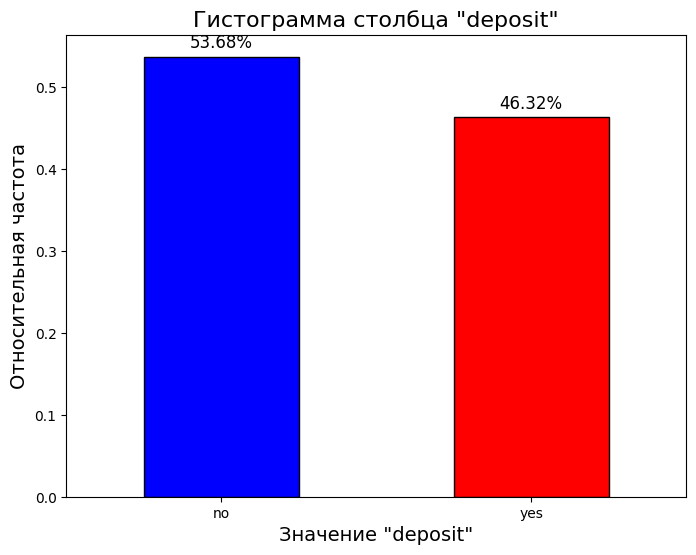

Количество открывших депозит 4681


In [475]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

plt.figure(figsize=(8, 6))
ax = filtered_df['deposit'].value_counts(normalize=True).plot(kind='bar', color=['blue', 'red'], edgecolor='black')

# Настройка графика
plt.title('Гистограмма столбца "deposit"', fontsize=16)
plt.xlabel('Значение "deposit"', fontsize=14)
plt.ylabel('Относительная частота', fontsize=14)
plt.xticks(rotation=0)

# Добавление фактических процентов
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.show()
print('Количество открывших депозит', filtered_df['deposit'].value_counts()[1])
# график несбалансированный

### Задания 2 и 3

In [476]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
filtered_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


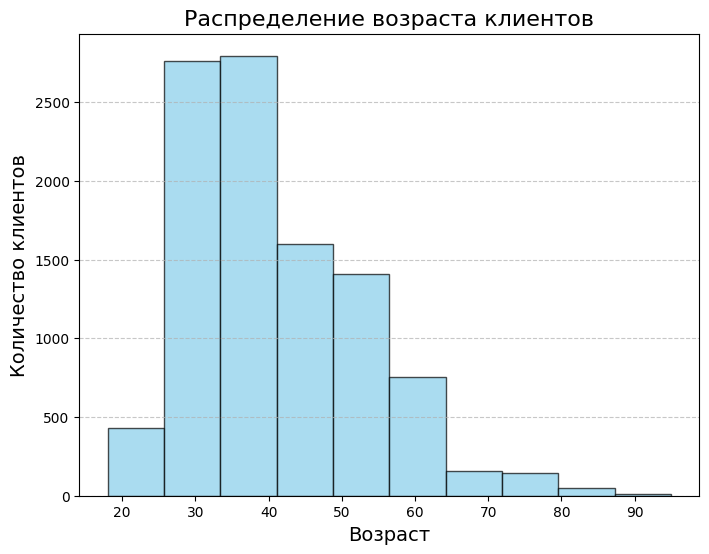

In [477]:
# Займемся признаком возраст
# Построение гистограммы распределения возраста
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['age'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)

# Настройка графика
plt.title('Распределение возраста клиентов', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
# Исходя из данных возраст 95 лет клента выбросом не является

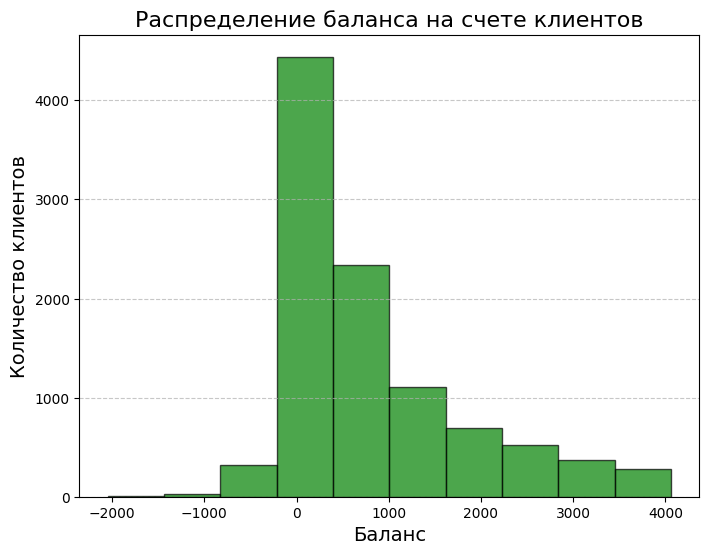

Количество клиентов с нулевым и отрицательным балансом: 1456
Доля клиентов с нулевым и отрицательным балансом от общего числа клиентов: 14.41%


In [478]:
# Займемся признаком баланс, настораживает у скольки клиентов отрицательный баланс
# Построение гистограммы распределения баланса
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['balance'], bins=10, color='green', edgecolor='black', alpha=0.7)

# Настройка графика
plt.title('Распределение баланса на счете клиентов', fontsize=16)
plt.xlabel('Баланс', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Подсчет клиентов с отрицательным балансом
negative_balance_clients = (filtered_df['balance'] <= 0).sum()

# Вычисление доли клиентов с отрицательным балансом от общего числа клиентов
fraction_negative_balance_clients = negative_balance_clients / len(filtered_df)

# Вывод результата
print(f"Количество клиентов с нулевым и отрицательным балансом: {negative_balance_clients}")
print(f"Доля клиентов с нулевым и отрицательным балансом от общего числа клиентов: {fraction_negative_balance_clients:.2%}")

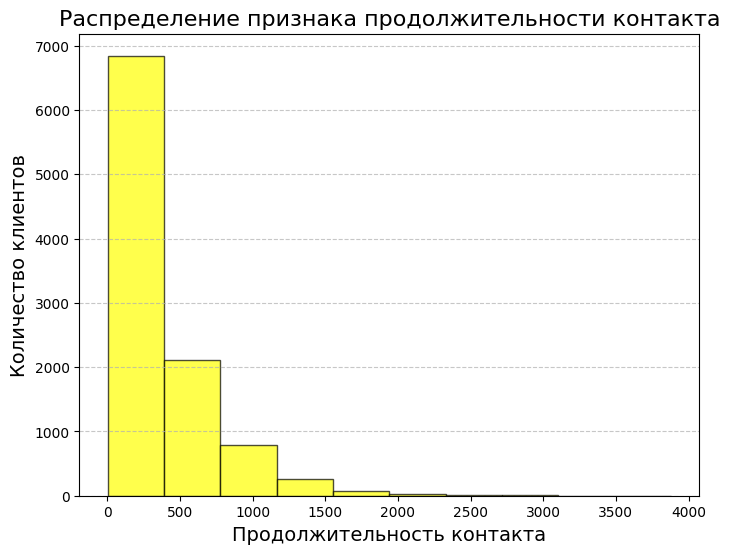

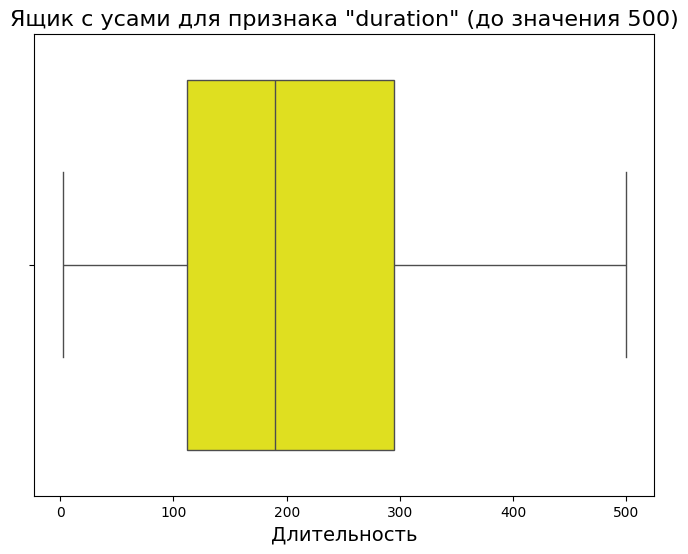

In [479]:
# Займемся признаком продолжительность контакта
# Построение гистограммы
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['duration'], bins=10, color='yellow', edgecolor='black', alpha=0.7)

# Настройка графика
plt.title('Распределение признака продолжительности контакта', fontsize=16)
plt.xlabel('Продолжительность контакта', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Исследуем продолжительность контактов до 500 секунд
# Построение ящика с усами
plt.figure(figsize=(8, 6))
sns.boxplot(x=filtered_df['duration'][filtered_df['duration'] <= 500],color='yellow')

# Настройка графика
plt.title('Ящик с усами для признака "duration" (до значения 500)', fontsize=16)
plt.xlabel('Длительность', fontsize=14)
plt.show()

# Продолжительность основной массы звонков от 100 до 300 секунд

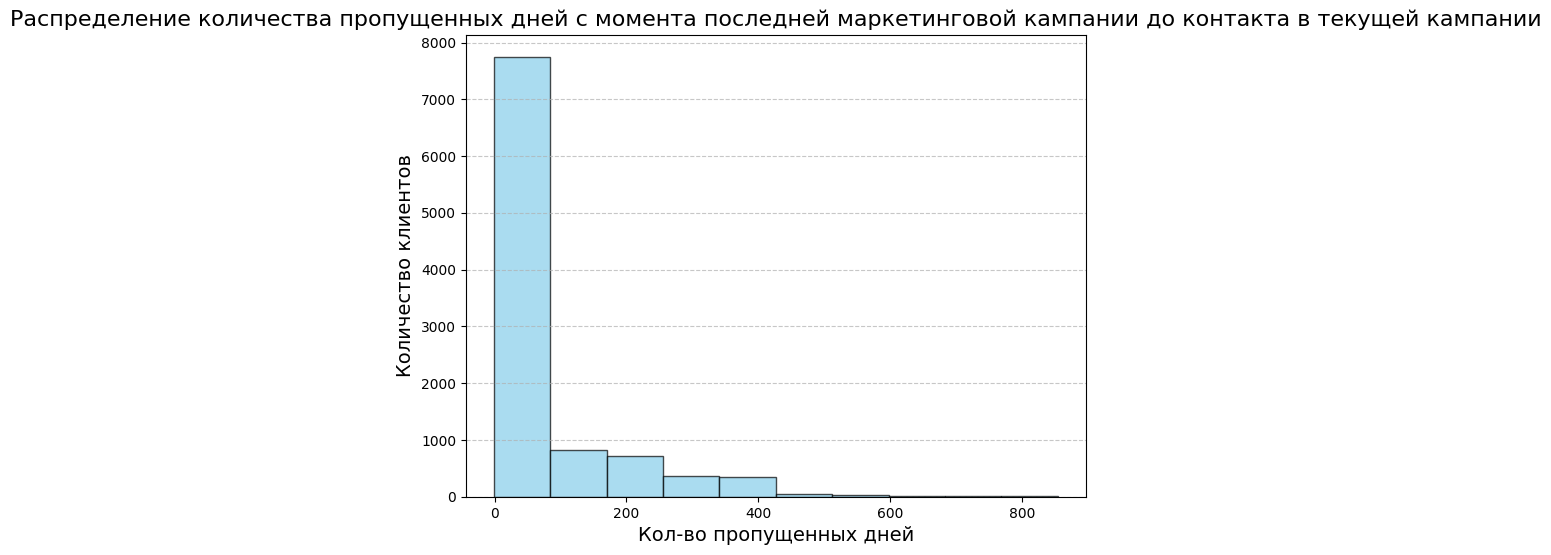

In [480]:
# Займемся признаком pdays
# Построение гистограммы распределения количества пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['pdays'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)

# Настройка графика
plt.title('Распределение количества пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании', fontsize=16)
plt.xlabel('Кол-во пропущенных дней', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

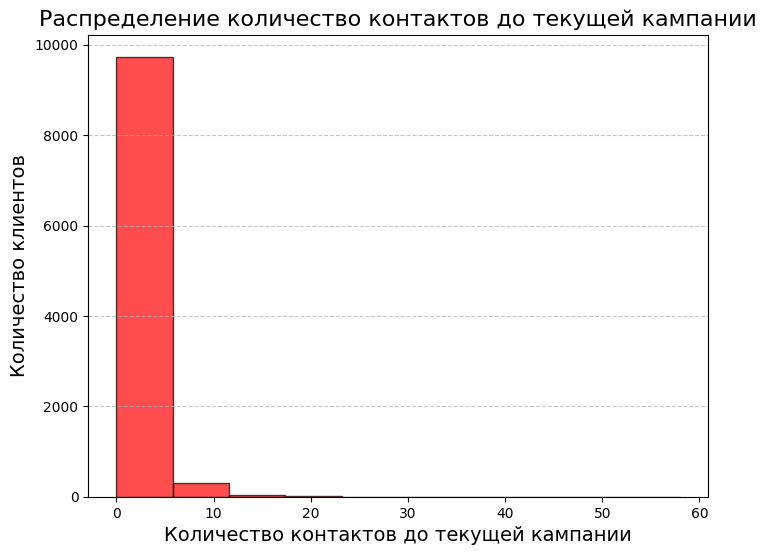

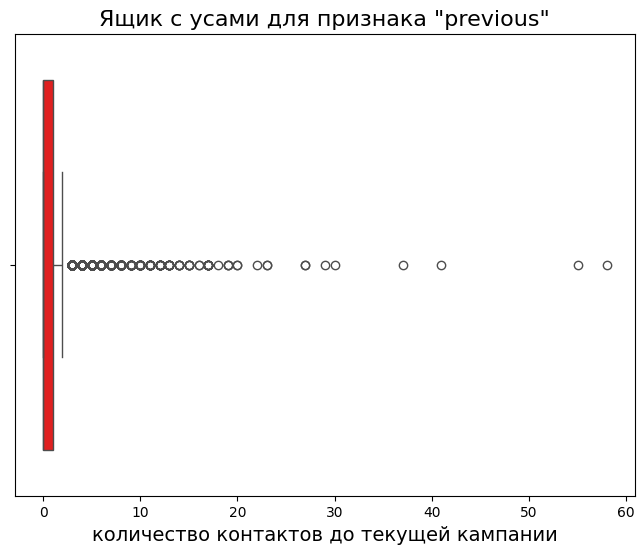

In [481]:
# Признак previous
# Построение гистограммы распределения количество контактов до текущей кампании
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['previous'], bins=10, color='red', edgecolor='black', alpha=0.7)

# Настройка графика
plt.title('Распределение количество контактов до текущей кампании', fontsize=16)
plt.xlabel('Количество контактов до текущей кампании', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Построение ящика с усами
plt.figure(figsize=(8, 6))
sns.boxplot(x=filtered_df['previous'],color='red')

# Настройка графика
plt.title('Ящик с усами для признака "previous"', fontsize=16)
plt.xlabel('количество контактов до текущей кампании', fontsize=14)
plt.show()

# Количество контактов для текущей компании в среднес до 5

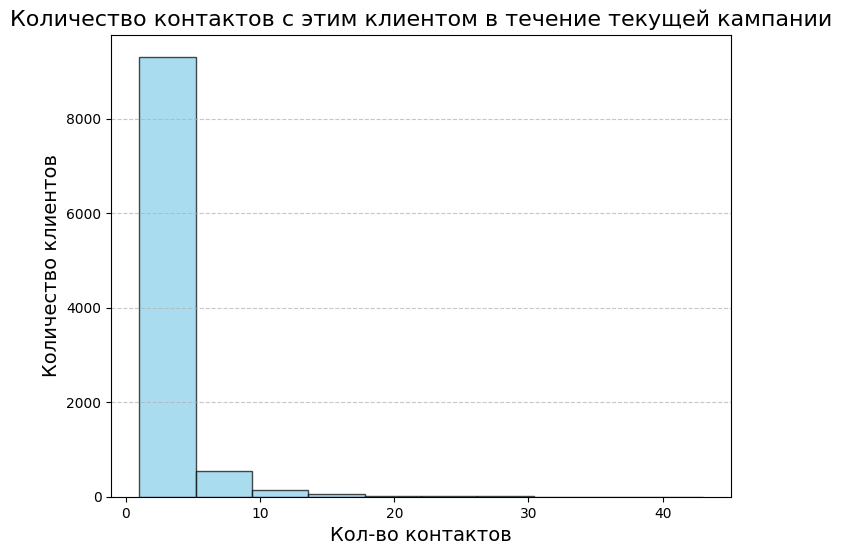

In [482]:
# Займемся признаком campaign
# Построение гистограммы распределения количество контактов с этим клиентом в течение текущей кампании
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['campaign'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)

# Настройка графика
plt.title('Количество контактов с этим клиентом в течение текущей кампании', fontsize=16)
plt.xlabel('Кол-во контактов', fontsize=14)
plt.ylabel('Количество клиентов', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Задания 4 и 5

In [483]:
# !pip install --upgrade seaborn matplotlib

In [484]:
# Получение описания категориальных признаков
filtered_df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student']


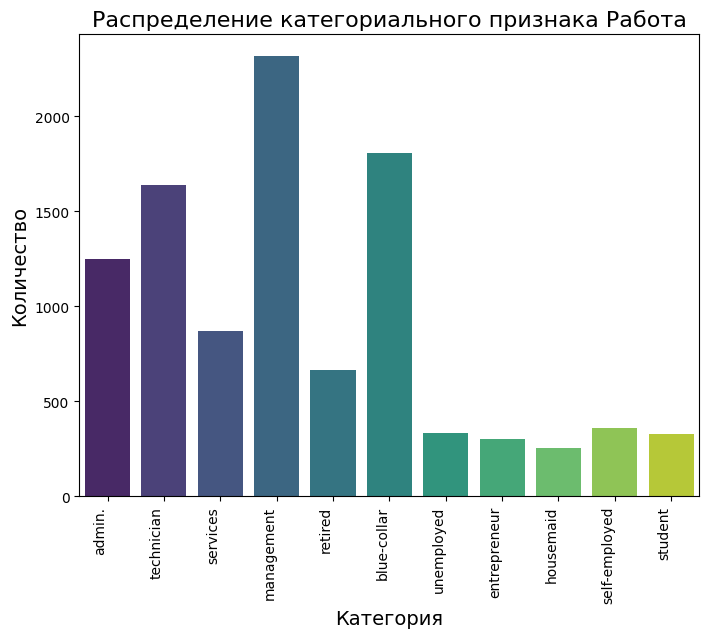

In [485]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
filtered_df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты
# Вывод уникальных значений в столбце 'category'
print(filtered_df['job'].unique())

# Визуализация распределения категориальных признаков с помощью countplot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='job', data=filtered_df, palette='viridis')

# Настройка графика
plt.title('Распределение категориального признака Работа', fontsize=16)
plt.xlabel('Категория', fontsize=14)
plt.ylabel('Количество', fontsize=14)

# Поворот значений признака на 90 градусов
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()

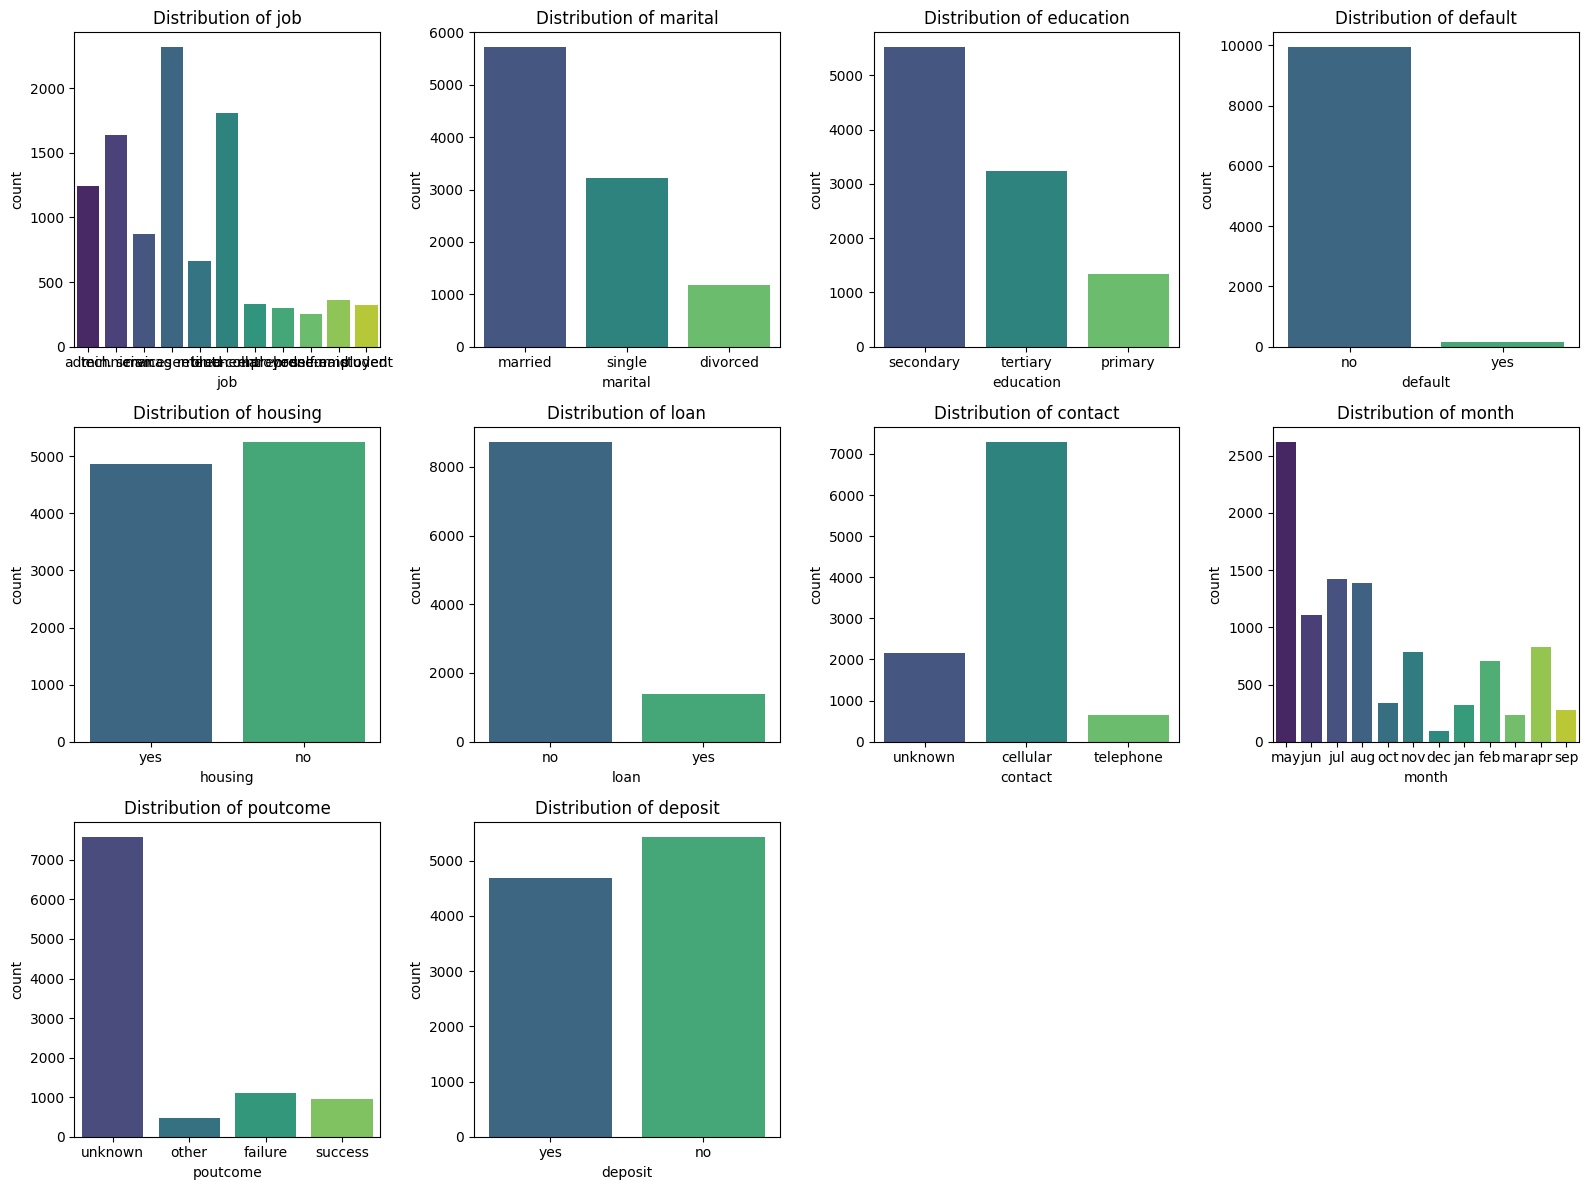

In [486]:
# Получение списка категориальных признаков
categorical_features = filtered_df.select_dtypes(include='object').columns.tolist()

# Определение количества строк и столбцов
nrows = len(categorical_features) // 4 + (len(categorical_features) % 4 > 0)
ncols = min(len(categorical_features), 4)

# Создание графиков для каждого категориального признака
plt.figure(figsize=(16, nrows * 4))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(nrows, ncols, i)
    sns.countplot(x=feature, data=filtered_df, palette='viridis')
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

### Задание 6

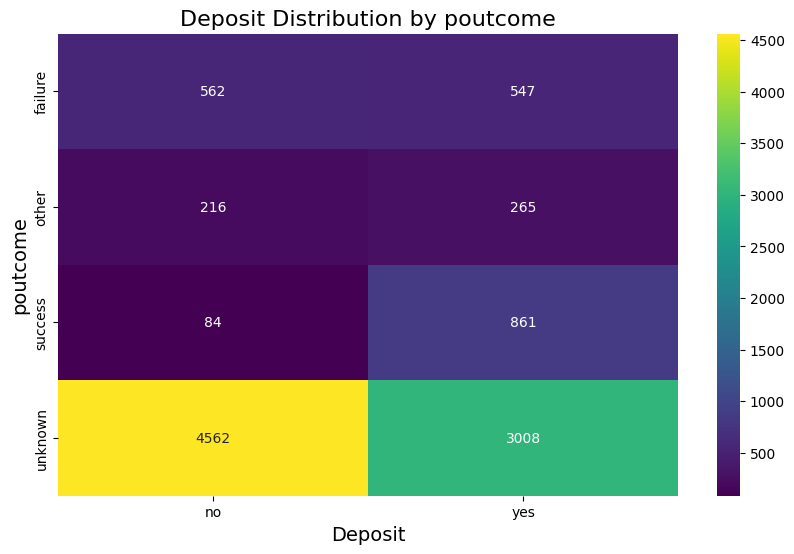

In [487]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код poutcome
# Агрегация по категориальному признаку 'poutcome' с учетом бинарного признака 'deposit'
aggregated_data = filtered_df.groupby(['poutcome', 'deposit']).size().unstack(fill_value=0)

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(aggregated_data, annot=True, cmap='viridis', fmt='d', cbar=True)
plt.title('Deposit Distribution by poutcome', fontsize=16)
plt.xlabel('Deposit', fontsize=14)
plt.ylabel('poutcome', fontsize=14)

plt.show()

### Задание 7

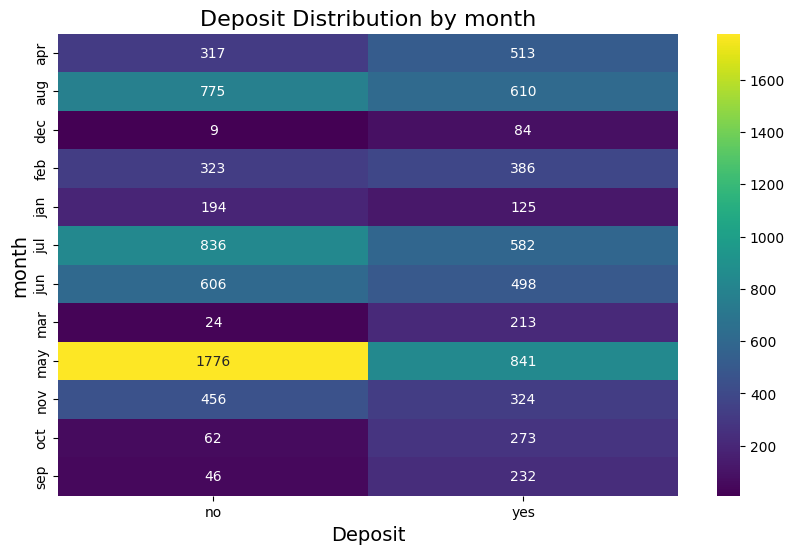

In [488]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

# Агрегация по категориальному признаку 'month' с учетом бинарного признака 'deposit'
aggregated_data = filtered_df.groupby(['month', 'deposit']).size().unstack(fill_value=0)

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(aggregated_data, annot=True, cmap='viridis', fmt='d', cbar=True)
plt.title('Deposit Distribution by month', fontsize=16)
plt.xlabel('Deposit', fontsize=14)
plt.ylabel('month', fontsize=14)

plt.show()

### Задание 8

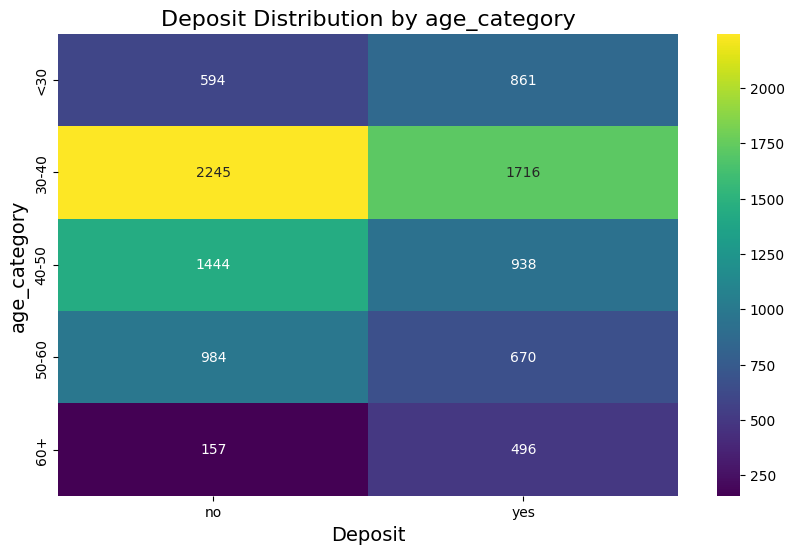

In [489]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Задаем интервалы для категорий
bins = [0, 30, 40, 50, 60, float('inf')]
labels = ['<30', '30-40', '40-50', '50-60', '60+']

# Создаем новую переменную с категориями
filtered_df['age_category'] = pd.cut(filtered_df['age'], bins=bins, labels=labels, right=False)
filtered_df = filtered_df.drop(columns='age')
# Агрегация по категориальному признаку 'age_category' с учетом бинарного признака 'deposit'
aggregated_data = filtered_df.groupby(['age_category', 'deposit']).size().unstack(fill_value=0)

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(aggregated_data, annot=True, cmap='viridis', fmt='d', cbar=True)
plt.title('Deposit Distribution by age_category', fontsize=16)
plt.xlabel('Deposit', fontsize=14)
plt.ylabel('age_category', fontsize=14)

plt.show()
# Выводы - до 30 лет и старше 60 люди охотнее открывают депозит, чем отказываются от открытия депозита

### Задания 9 и 10

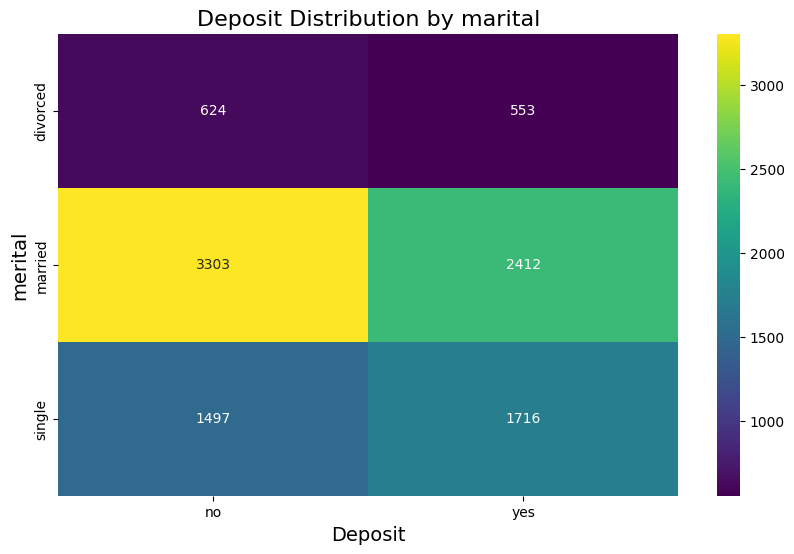

In [490]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
# Агрегация по категориальному признаку 'marital' с учетом бинарного признака 'deposit'
aggregated_data = filtered_df.groupby(['marital', 'deposit']).size().unstack(fill_value=0)

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(aggregated_data, annot=True, cmap='viridis', fmt='d', cbar=True)
plt.title('Deposit Distribution by marital', fontsize=16)
plt.xlabel('Deposit', fontsize=14)
plt.ylabel('merital', fontsize=14)

plt.show()
# Выводы - у одиноких людей конверсия в открытие депозита выше чем у семейных и разведенных людей

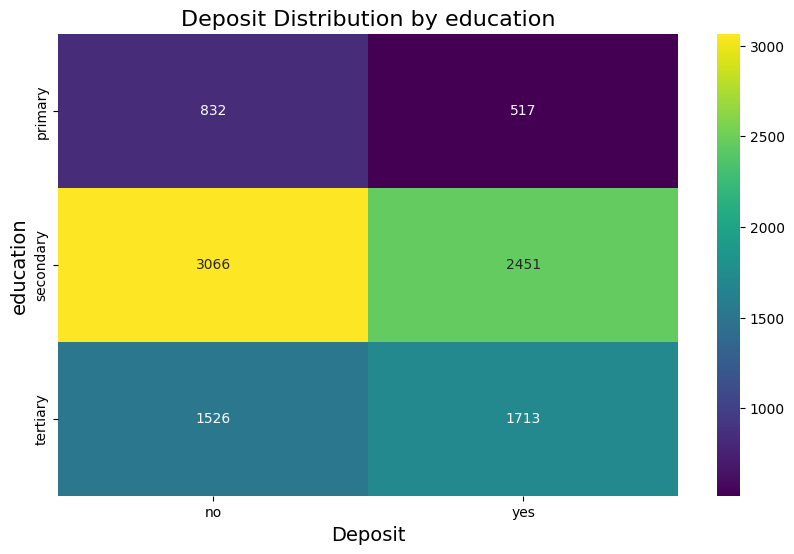

In [491]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
# Агрегация по категориальному признаку 'education' с учетом бинарного признака 'deposit'
aggregated_data = filtered_df.groupby(['education', 'deposit']).size().unstack(fill_value=0)

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(aggregated_data, annot=True, cmap='viridis', fmt='d', cbar=True)
plt.title('Deposit Distribution by education', fontsize=16)
plt.xlabel('Deposit', fontsize=14)
plt.ylabel('education', fontsize=14)

plt.show()
# Выводы - конверсия в открытие депозит для лиц с тремя образованиями выше, на втором месте люди с 2мя и на третьем месте с 1 образованием

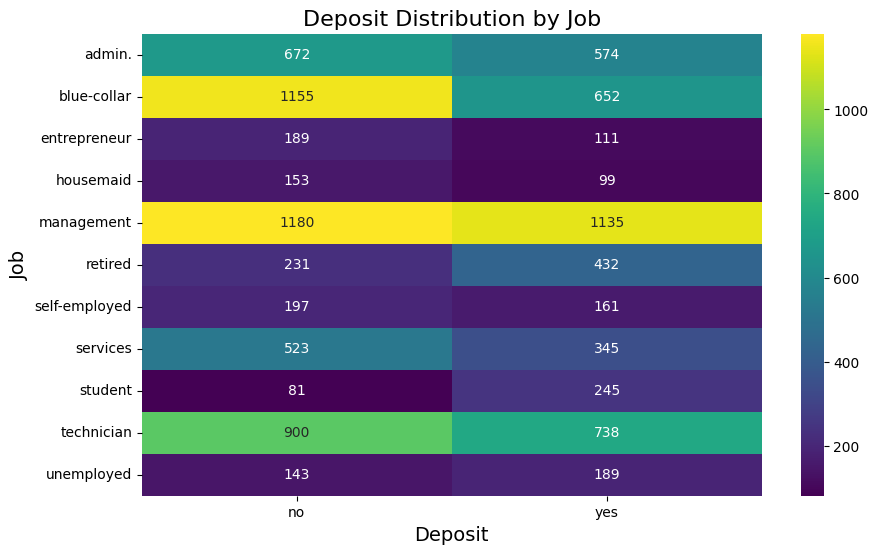

In [492]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
# Агрегация по категориальному признаку 'job' с учетом бинарного признака 'deposit'
aggregated_data = filtered_df.groupby(['job', 'deposit']).size().unstack(fill_value=0)

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(aggregated_data, annot=True, cmap='viridis', fmt='d', cbar=True)
plt.title('Deposit Distribution by Job', fontsize=16)
plt.xlabel('Deposit', fontsize=14)
plt.ylabel('Job', fontsize=14)

plt.show()

# Выводы: Максимальная конверсия в продажу среди специалистов у синих воротничков и минимальная у студентов

### Задание 11

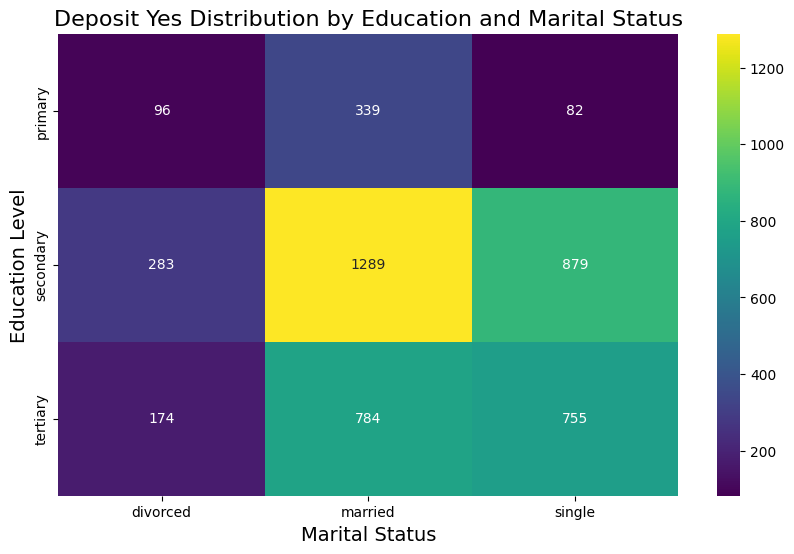

In [493]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Разделение на два датафрейма
deposit_yes_df = filtered_df[filtered_df['deposit'] == 'yes']
deposit_no_df = filtered_df[filtered_df['deposit'] == 'no']
# Создаем сводную таблицу для тех, кто открыл депозит
pivot_table = deposit_yes_df.pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='d', cbar=True)
plt.title('Deposit Yes Distribution by Education and Marital Status', fontsize=16)
plt.xlabel('Marital Status', fontsize=14)
plt.ylabel('Education Level', fontsize=14)

plt.show()

# Наиболее многочисленны люди семейны с 2 образованиями

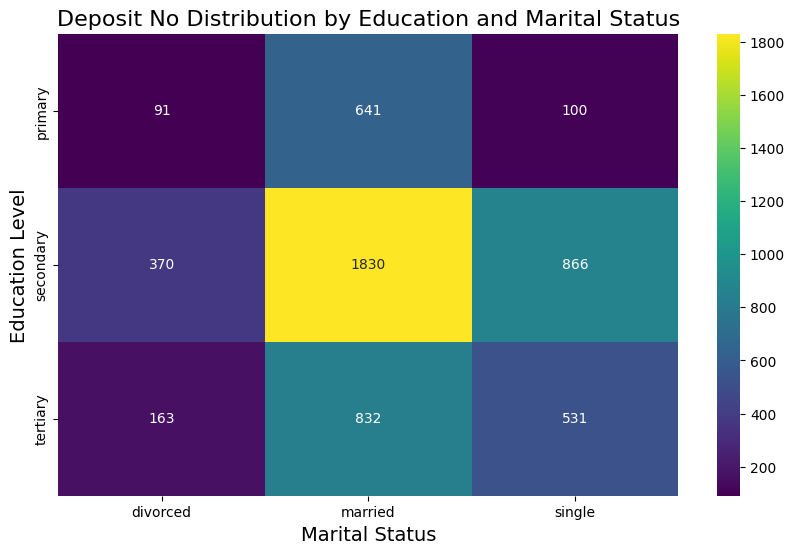

In [494]:
# Создаем сводную таблицу для тех, кто не открыл депозит
pivot_table = deposit_no_df.pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='d', cbar=True)
plt.title('Deposit No Distribution by Education and Marital Status', fontsize=16)
plt.xlabel('Marital Status', fontsize=14)
plt.ylabel('Education Level', fontsize=14)

plt.show()
# Наиболее многочисленны люди семейны с 2 образованиями

## Часть 3: преобразование данных

### Задание 1

In [495]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder

# Инициализация LabelEncoder
label_encoder = LabelEncoder()

# Применение LabelEncoder к признаку education
filtered_df['education_encoded'] = label_encoder.fit_transform(filtered_df['education'])

# Вывод суммы получившегося признака
print(filtered_df['education_encoded'].sum())

11995


### Задания 2 и 3

In [496]:
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df['deposit'] = lab_enc.fit_transform(df['deposit'])

df['deposit'].std()

0.49933754391208757

In [497]:
# преобразуйте бинарные переменные в представление из нулей и единиц
filtered_df.age_category
# Инициализация LabelEncoder
label_encoder = LabelEncoder()

# Применение LabelEncoder к признаку education
filtered_df['age_category_encoded'] = label_encoder.fit_transform(filtered_df['age_category'])

# Кодируем бинарный признак целевой переменной
filtered_df['deposit_encoded'] = filtered_df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
filtered_df['default_encoded'] = filtered_df['default'].apply(lambda x: 1 if x == 'yes' else 0)
filtered_df['housing_encoded'] = filtered_df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
filtered_df['loan_encoded'] = filtered_df['loan'].apply(lambda x: 1 if x == 'yes' else 0)
print((filtered_df['default_encoded'].mean() + filtered_df['housing_encoded'].mean() + filtered_df['loan_encoded'].mean()).round(3))

0.635


In [498]:
# Создание dummy-переменных для номинальных переменных 'job', 'marital', 'contact', 'month', 'poutcome'
dummy_variables = pd.get_dummies(filtered_df[['job', 'marital', 'contact', 'month', 'poutcome']], drop_first=True)

# Добавление dummy-переменных к исходному датафрейму
filtered_df = pd.concat([filtered_df, dummy_variables], axis=1)

# Вывод результата
filtered_df.shape

(10105, 51)

### Задание 4

In [499]:
# создайте дамми-переменные
# Удаление исходных категориальных переменных, так как теперь у нас есть их dummy-переменные
filtered_df.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1, inplace=True)
filtered_df.shape

(10105, 46)

### Задания 5 и 6

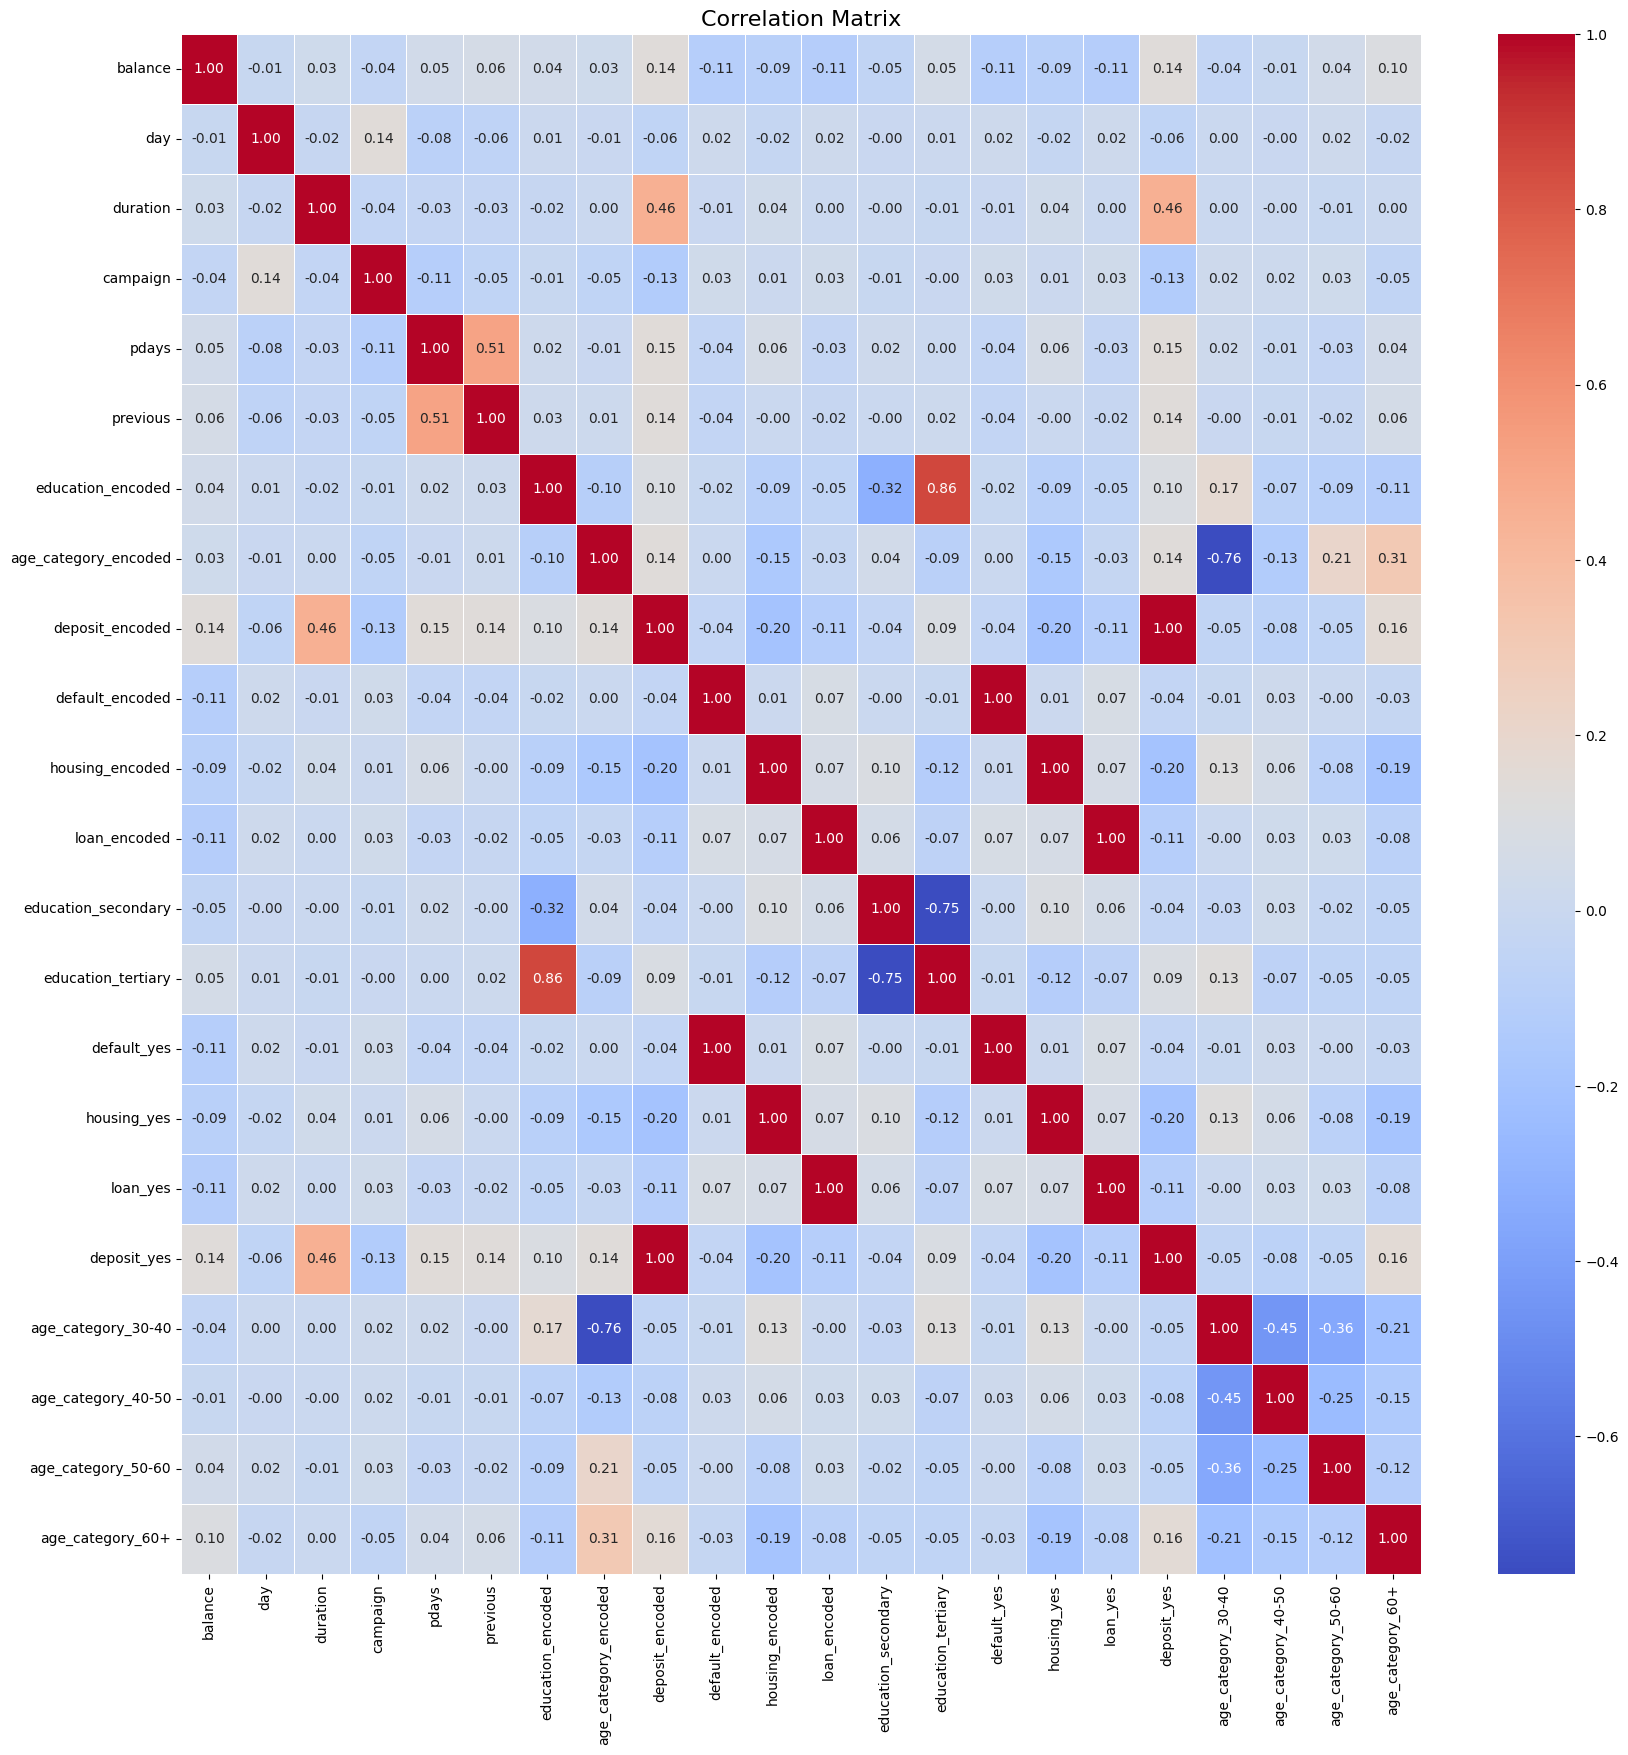

In [500]:
# Отделяем числовые и категориальные признаки
numerical_cols = filtered_df.select_dtypes(include=['number']).columns
categorical_cols = filtered_df.select_dtypes(include=['object', 'category']).columns

# Преобразуем категориальные данные в dummy переменные
filtered_encoded = pd.get_dummies(filtered_df[categorical_cols], drop_first=True)

# Создаем объединенный DataFrame для корреляции
data_for_corr = pd.concat([filtered_df[numerical_cols], filtered_encoded], axis=1)

# Строим корреляционную матрицу
correlation_matrix = data_for_corr.corr()

# Визуализация с увеличенным размером
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

### Задания 7 и 8

In [501]:
X = filtered_df.drop(['deposit_encoded'], axis=1)
y = filtered_df['deposit_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(X_test.shape)

(3335, 45)


In [502]:
# рассчитайте необходимые показатели
X_test.shape
y_test.mean().round(2)

np.float64(0.46)

### Задание 9

In [503]:
# Убираем нечисловые признаки
# Выбор числовых признаков
X = filtered_df.select_dtypes(include=['number']).drop(['deposit_encoded'], axis=1)

In [504]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif

# Инициализация SelectKBest с использованием f_classif
selector = SelectKBest(score_func=f_classif, k=15)

# Применение SelectKBest к обучающим данным
X_new = selector.fit_transform(X, y)

# Получение индексов отобранных признаков
selected_feature_indices = selector.get_support(indices=True)

# Получение списка имен отобранных признаков
selected_feature_names = X.columns[selected_feature_indices]

# Вывод результата
print("Отобранные признаки:")
print(selected_feature_names)

Отобранные признаки:
Index(['balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'education_encoded', 'age_category_encoded', 'default_encoded',
       'housing_encoded', 'loan_encoded'],
      dtype='object')


### Задание 10

In [505]:
from sklearn.preprocessing import MinMaxScaler

# нормализуйте данные с помощью minmaxsxaler
X_train, X_test, y_train, y_test = train_test_split(X_new, y, stratify=y, random_state = 42, test_size = 0.2)

# Инициализация объекта MinMaxScaler
scaler = MinMaxScaler()

# Применение нормализации к X_train
X_train_scaled = scaler.fit_transform(X_train)

# Применение тех же параметров нормализации к X_test
X_test_scaled = scaler.transform(X_test)

# Вывод результата
print(X_test_scaled[:, 0].mean().round(2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [506]:
# обучите логистическую регрессию и рассчитайте метрики качества
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Создадим модель логистической регрессии с параметром оптимизации 'sag' и random_state=42
model = LogisticRegression(solver='sag', random_state=42, max_iter=1000)

# Обучим модель на обучающем наборе данных
model.fit(X_train_scaled, y_train)

# Предскажем значения на тестовом наборе данных
y_pred = model.predict(X_test_scaled)

# Оценим точность модели
# accuracy = np.mean(y_pred == y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {round(accuracy, 2)}")

Точность модели: 0.77


### Задания 2,3,4

In [507]:
# обучите решающие деревья, настройте максимальную глубину
from sklearn.tree import DecisionTreeClassifier

# Создадим модель решающего дерева с заданными параметрами
tree_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Обучим модель решающего дерева на обучающем наборе данных
tree_model.fit(X_train_scaled, y_train)

# Предскажем значения на тестовом наборе данных
tree_y_pred_test = tree_model.predict(X_test_scaled)

# Оценим точность модели решающего дерева
tree_accuracy = accuracy_score(y_test, tree_y_pred_test)
print(f"Точность модели решающего дерева: {tree_accuracy}")

# Предскажем значения на обучающей выборке
tree_y_pred_train = tree_model.predict(X_train_scaled)

# Оценим точность модели решающего дерева на обучающей выборке
tree_accuracy_train = accuracy_score(y_train, tree_y_pred_train)
print(f"Точность модели решающего дерева на тренировочной выборке: {tree_accuracy_train}")

Точность модели решающего дерева: 0.7506185056902523
Точность модели решающего дерева на тренировочной выборке: 1.0


In [508]:
!pip install --upgrade scikit-learn

In [509]:
import sklearn
# Проверим гипотезу о переобучении нашего дерева с помощью кросс-валидации k-fold
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = sklearn.model_selection.StratifiedKFold(n_splits=5)

#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = sklearn.model_selection.cross_validate(
    estimator=tree_model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
## Train k-fold mean f1: 1.00
## Valid k-fold mean f1: 0.71

{'fit_time': array([0.06512952, 0.05770755, 0.09240627, 0.09429193, 0.23440385]),
 'score_time': array([0.00544167, 0.00511122, 0.00994349, 0.01122308, 0.01556587]),
 'test_score': array([0.67787115, 0.64142283, 0.70382514, 0.74423592, 0.70518994]),
 'train_score': array([1., 1., 1., 1., 1.])}

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.69


### Задание 5

In [510]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth': [3,5,7],
              'min_samples_split': [2, 5, 7, 10]}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=1  # Set n_jobs to 1
)
grid_search.fit(X_train_scaled, y_train)


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_depth': [3, 5, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,None
,n_jobs,1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


In [511]:
# Альтернативный вариант реализации
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid#,
    #cv=5,
    #n_jobs=-1  # Set n_jobs to 1
)
from joblib import parallel_backend

with parallel_backend('threading'):
    grid_search.fit(X_train_scaled, y_train)

In [512]:
# Теперь можно использовать другие атрибуты или методы
print("accuracy на обучающем наборе: {:.2f}".format(grid_search.score(X_train_scaled, y_train)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

accuracy на обучающем наборе: 0.82
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [513]:
# обучите на ваших данных случайный лес
from sklearn.ensemble import RandomForestClassifier

# Ваши параметры
n_estimators = 100
criterion = 'gini'
min_samples_leaf = 5
max_depth = 10
random_state = 42

# Создание модели случайного леса
random_forest = RandomForestClassifier(
    n_estimators=n_estimators,
    criterion=criterion,
    min_samples_leaf=min_samples_leaf,
    max_depth=max_depth,
    random_state=random_state
)

# Обучение модели на вашем наборе данных
# X_train и y_train - ваши обучающие данные и метки
random_forest.fit(X_train_scaled, y_train)

# Теперь ваш случайный лес обучен и готов к использованию


,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [514]:
from sklearn.metrics import accuracy_score, recall_score

# Прогнозы на тестовых данных
y_pred = random_forest.predict(X_test_scaled)

# Оценка accuracy
accuracy = accuracy_score(y_test, y_pred)

# Оценка recall
recall = recall_score(y_test, y_pred)

# Вывод результатов
print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.81
Recall: 0.82


### Задания 2 и 3

In [515]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score

# Ваши параметры
learning_rate = 0.05
n_estimators = 300
min_samples_leaf = 5
max_depth = 5
random_state = 42

# Создание модели градиентного бустинга
gradient_boosting = GradientBoostingClassifier(
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    max_depth=max_depth,
    random_state=random_state
)

# Обучение модели на обучающих данных
gradient_boosting.fit(X_train_scaled, y_train)

# Прогнозы на тестовых данных
y_pred_gb = gradient_boosting.predict(X_test_scaled)

# Оценка accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)

# Оценка recall
recall_gb = recall_score(y_test, y_pred_gb)

# Вывод результатов
print(f'Gradient Boosting Accuracy: {accuracy_gb:.2f}')
print(f'Gradient Boosting Recall: {recall_gb:.2f}')

Gradient Boosting Accuracy: 0.81
Gradient Boosting Recall: 0.81


### Задание 4

In [516]:
# объедините уже известные вам алгоритмы с помощью стекинга
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

,estimators,"[('dt', ...), ('log_reg', ...), ...]"
,final_estimator,LogisticRegre...ndom_state=42)
,cv,None
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,criterion,'entropy'
,splitter,'best'
,max_depth,6
,min_samples_split,2


### Задание 5

In [517]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.metrics import precision_score

# Получение предсказаний на тестовой выборке
y_pred = stack.predict(X_test_scaled)

# Вычисление метрики precision
precision = precision_score(y_test, y_pred)

# Вывод результата с округлением до двух знаков после точки-разделителя
print(f'Precision: {precision:.2f}')

Precision: 0.79


### Задания 6,7,8

Feature importance:
duration: 0.6170713413085964
pdays: 0.1256615779632911
housing_encoded: 0.10446670005886599
age_category_encoded: 0.04302321660135786
previous: 0.02779051235163326
balance: 0.02715761448119991
day: 0.019535658798287423
campaign: 0.014724659747578365
loan_encoded: 0.010243590656580523
education_encoded: 0.010042346575179257
default_encoded: 0.0002827814574299879


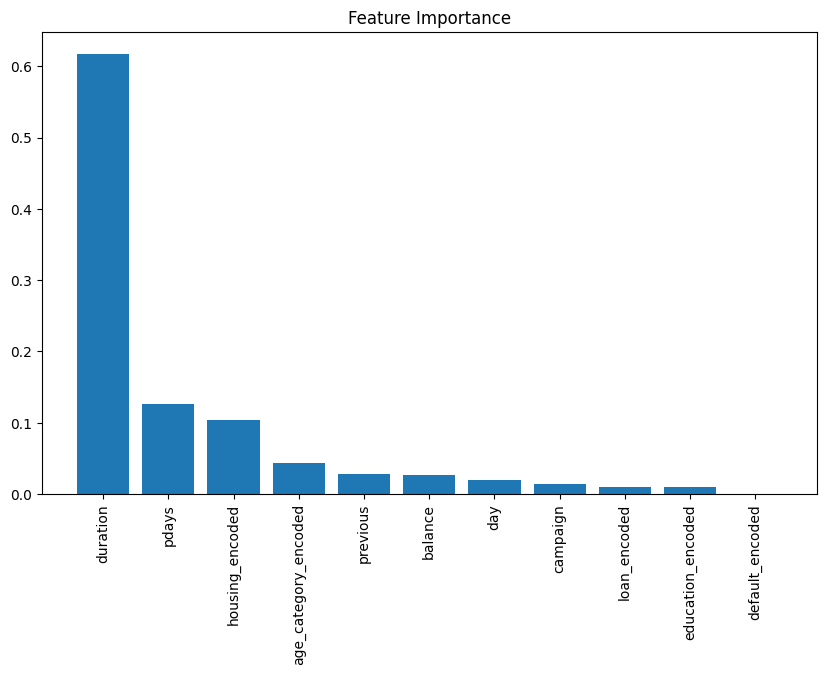

In [518]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt

# Создание и обучение модели
gb = GradientBoostingClassifier()
gb.fit(X_train_scaled, y_train)

# Получение важности признаков
importance = gb.feature_importances_

# Сортировка признаков по их важности
indices = np.argsort(importance)[::-1]

# Вывод важности признаков
print("Feature importance:")
for f in range(X_train_scaled.shape[1]):
    print(f"{selected_feature_names[indices[f]]}: {importance[indices[f]]}")

# Визуализация важности признаков (опционально)
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_scaled.shape[1]), importance[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), [selected_feature_names[i] for i in indices], rotation=90)
plt.title("Feature Importance")
plt.show()

In [519]:
!pip install optuna

In [520]:
# Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch.
# Однако вы знаете, что это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna.
# Примените его для оптимизации гиперпараметров. Для перебора возьмите случайный лес и следующие параметры:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))

  return score

In [521]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-10-07 15:05:06,810] A new study created in memory with name: RandomForestClassifier
[I 2025-10-07 15:05:11,035] Trial 0 finished with value: 0.8041994750656168 and parameters: {'n_estimators': 189, 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8041994750656168.
[I 2025-10-07 15:05:14,298] Trial 1 finished with value: 0.8021052631578948 and parameters: {'n_estimators': 185, 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8041994750656168.
[I 2025-10-07 15:05:17,110] Trial 2 finished with value: 0.8050579557428873 and parameters: {'n_estimators': 114, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8050579557428873.
[I 2025-10-07 15:05:23,603] Trial 3 finished with value: 0.8037775445960126 and parameters: {'n_estimators': 189, 'max_depth': 24, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8050579557428873.
[I 2025-10-07 15:05:25,596] Trial 4 finished with value: 0.79979035639413 and parameters: {'n_es

CPU times: user 37.7 s, sys: 77.4 ms, total: 37.8 s
Wall time: 50.1 s


In [522]:
# выводим результаты на тестовой выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на тестовом наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 114, 'max_depth': 23, 'min_samples_leaf': 2}
f1_score на тестовом наборе: 0.81


In [523]:
def optuna_rf_accuracy_score(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.accuracy_score(y_test, model.predict(X_test_scaled))

  return score


# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf_accuracy_score, n_trials=20)

[I 2025-10-07 15:05:56,917] A new study created in memory with name: RandomForestClassifier
[I 2025-10-07 15:05:58,649] Trial 0 finished with value: 0.8159327065809006 and parameters: {'n_estimators': 129, 'max_depth': 24, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8159327065809006.
[I 2025-10-07 15:06:01,753] Trial 1 finished with value: 0.8144482929242949 and parameters: {'n_estimators': 146, 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8159327065809006.
[I 2025-10-07 15:06:07,598] Trial 2 finished with value: 0.8144482929242949 and parameters: {'n_estimators': 192, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8159327065809006.
[I 2025-10-07 15:06:10,859] Trial 3 finished with value: 0.8129638792676893 and parameters: {'n_estimators': 144, 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8159327065809006.
[I 2025-10-07 15:06:12,837] Trial 4 finished with value: 0.8184067293419099 and parameters: {'n_

In [524]:
# выводим результаты на тестовой выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("accuracy на тестовом наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 106, 'max_depth': 19, 'min_samples_leaf': 6}
accuracy на тестовом наборе: 0.82
